# Домашняя работа

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

#### 1. Провести анализ данных. 

In [2]:
#Загружаем исходные данные
data = pd.read_csv('Kobe.csv')
_ = data.action_type.count()

#В задании на Kaggle искуственно очистили результат 5000 бросков ('shot_made_flag'), удаляем соответствующие строки.
data = data.dropna()
print(f'Количество строк было: {_}, стало после обработки: {data.action_type.count()}.')

Количество строк было: 30697, стало после обработки: 25697.


In [3]:
# Обработка категориальнай полей
# Удаляем:
# 'team_name'='Los Angeles Lakers',
# 'matchup' повторяется в 'opponent',
# 'combined_shot_type' повторяется в 'action_type'
# идентификаторы не нужны: 'team_id', 'game_event_id', 'game_id', 'shot_id'
lstDropFiled = ['team_name', 'matchup', 'combined_shot_type', 'team_id', 'game_event_id', 'game_id', 'shot_id']
data.drop(lstDropFiled, axis=1, inplace = True)

In [4]:
data.head()

,action_type,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,opponent
1,Jump Shot,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,2000-10-31,POR
2,Jump Shot,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,2000-10-31,POR
3,Jump Shot,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,2000-10-31,POR
4,Driving Dunk Shot,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,2000-10-31,POR
5,Jump Shot,34.0553,-145,-11,-118.4148,9,3,0,2000-01,32,14,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,2000-10-31,POR


#### 2. Подготовить фичи для обучения модели 

In [5]:
#Преобразование категориальных переменных

#Зоны игры по удаленности от корзины
dictShot_zone_range = { 'Back Court Shot':-1,
                        'Less Than 8 ft.': 0,
                        '8-16 ft.'       : 1,
                        '16-24 ft.'      : 2,
                        '24+ ft.'        : 3 }

#Распределение методов обработки по категориальным полям
data_trans = { 'action_type'    :'ohe', #Способ подбора, веса не присваивать
               'season'         :'le',  #Сезоны идентифицируем
               'shot_type'      :'ohe', #Способ броска, веса не присваивать
               'shot_zone_area' :'ohe', #Зона броска, веса не присваивать
               'shot_zone_basic':'ohe', #Основная зона броска, веса не присваивать
               'game_date'      :'le',  #Дата игры
               'opponent'       :'ohe' } #Протевник, веса не присваивать

df = pd.DataFrame()

#Кодирование категориальных переменных
for key in data_trans.keys():
    if data_trans[key] == 'ohe':
        _ = pd.get_dummies(data[key], prefix=key, drop_first=False)
        df = pd.concat([df, _], axis=1)
    elif data_trans[key] == 'le':
        le = LabelEncoder()
        df[key] = le.fit_transform(data[key])

df['shot_zone_range'] = data['shot_zone_range'].map(dictShot_zone_range)

df = pd.concat([df, data.select_dtypes(exclude=['object'])], axis=1)

In [6]:
#data.dtypes[data.dtypes == 'object'].index
#data[ data.dtypes[data.dtypes == 'object'].index ]

#### 3. Обучить линейную модель, Lasso, Ridge

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

lr = LogisticRegression()
lr.fit(X, y)

la = LassoCV()
la.fit(X, y)

ri = RidgeCV()
ri.fit(X, y)


D:\Anakonda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [8]:
coef = pd.DataFrame({'X':                  X.columns,
                     'LogisticRegression': lr.coef_[0],
                     'LassoCV':            la.coef_,
                     'RidgeCV':            ri.coef_}) 

coef[coef['LassoCV']!= 0]

,X,LogisticRegression,LassoCV,RidgeCV
25,action_type_Jump Shot,-0.975026,-0.303042,-0.397858
26,action_type_Layup Shot,-0.415582,-0.223484,-0.338864
71,game_date,0.000647,-0.000037,0.000242
105,shot_zone_range,0.191879,0.012236,0.051510
107,loc_x,-0.000061,0.000040,-0.000063
108,loc_y,0.000266,0.000207,0.000009
110,minutes_remaining,0.015868,0.002480,0.003119
111,period,-0.257772,-0.006185,-0.011988
113,seconds_remaining,0.002465,0.000700,0.000736
114,shot_distance,-0.034109,-0.005193,-0.000061


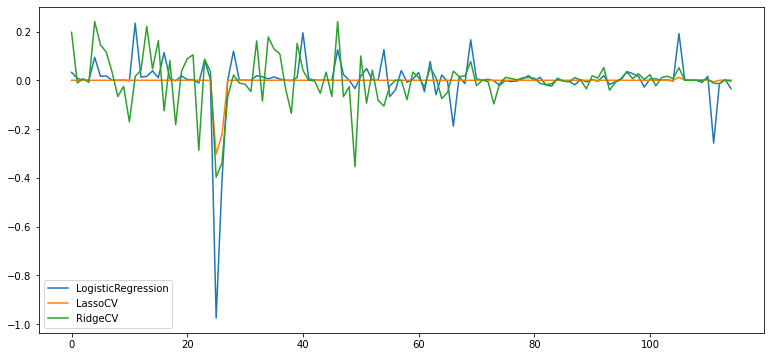

In [9]:
#Построение графика коэффициентов
from pylab import rcParams
rcParams['figure.figsize'] = 13,6

plt.plot(coef['LogisticRegression'], label = 'LogisticRegression')
plt.plot(coef['LassoCV'], label = 'LassoCV')
plt.plot(coef['RidgeCV'], label = 'RidgeCV')
plt.legend( loc = 0 )
plt.show()

#### Вывод  
Коэффициенты, которые оказывают не значительное влияние на результат классификации, по каждой из модели.  
Важность регуляризации.

In [10]:
list(coef[coef['LogisticRegression'].abs() < 0.00001]['X'])

[]

In [11]:
list(coef[coef['RidgeCV'].abs() < 0.00001]['X'])

['lat', 'loc_y', 'lon']

In [12]:
list(coef[coef['LassoCV'] == 0]['X'])

['action_type_Alley Oop Dunk Shot',
 'action_type_Alley Oop Layup shot',
 'action_type_Cutting Layup Shot',
 'action_type_Driving Bank shot',
 'action_type_Driving Dunk Shot',
 'action_type_Driving Finger Roll Layup Shot',
 'action_type_Driving Finger Roll Shot',
 'action_type_Driving Floating Bank Jump Shot',
 'action_type_Driving Floating Jump Shot',
 'action_type_Driving Hook Shot',
 'action_type_Driving Jump shot',
 'action_type_Driving Layup Shot',
 'action_type_Driving Reverse Layup Shot',
 'action_type_Driving Slam Dunk Shot',
 'action_type_Dunk Shot',
 'action_type_Fadeaway Bank shot',
 'action_type_Fadeaway Jump Shot',
 'action_type_Finger Roll Layup Shot',
 'action_type_Finger Roll Shot',
 'action_type_Floating Jump shot',
 'action_type_Follow Up Dunk Shot',
 'action_type_Hook Bank Shot',
 'action_type_Hook Shot',
 'action_type_Jump Bank Shot',
 'action_type_Jump Hook Shot',
 'action_type_Pullup Bank shot',
 'action_type_Pullup Jump shot',
 'action_type_Putback Dunk Shot',
 '

#### 4. Сравнить результаты на тестовом наборе данных

D:\Anakonda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


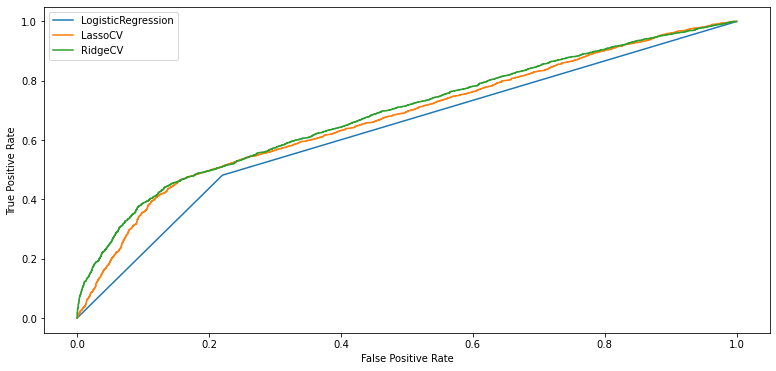

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

#Разделение наблюдений на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

#Обучение моделей на тренировочных данных
lr.fit(X_train, y_train)
la.fit(X_train, y_train)
ri.fit(X_train, y_train)

#Определение параметров для построения roc-кривой
fpr, tpr, thres    = roc_curve( y_test, lr.predict(X_test) )
fpr2, tpr2, thres2 = roc_curve( y_test, la.predict(X_test) )
fpr3, tpr3, thres3 = roc_curve( y_test, ri.predict(X_test) )

plt.plot( fpr,  tpr,  label = 'LogisticRegression' )
plt.plot( fpr2, tpr2, label = 'LassoCV' )
plt.plot( fpr3, tpr3, label = 'RidgeCV' )

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend( loc = 0 )
plt.show()

#### 5. Построить PCA

In [14]:
from sklearn.decomposition import PCA
pcaX = PCA( n_components = round(len(X.columns)/5) )
X_pca = pcaX.fit_transform(X)

list(zip(pcaX.components_[0], pcaX.explained_variance_ratio_))

[(2.158906438953778e-06, 0.8941934005955772),
 (4.523933024902624e-07, 0.06342163972215907),
 (-9.489268981679104e-07, 0.04054534750874593),
 (-1.8112315176214256e-07, 0.0016006441218449487),
 (4.954725570340732e-06, 0.00015427218381214094),
 (-4.622802176298939e-06, 6.19787271275903e-05),
 (3.1375685910196862e-06, 6.917315485090318e-06),
 (-1.596901943225599e-07, 2.548891245789366e-06),
 (-4.6807586958587415e-07, 1.393350802365935e-06),
 (-1.0549660463478243e-06, 1.3103484254066298e-06),
 (-2.2486752156415755e-06, 9.726662754545947e-07),
 (4.6784596523282164e-05, 7.276589106627913e-07),
 (-7.993159543516835e-06, 5.95255852477763e-07),
 (-3.3173247082510625e-06, 5.046758247243642e-07),
 (8.058334339468796e-06, 4.7447883103035956e-07),
 (-1.9810230992678058e-06, 3.8194444615883967e-07),
 (-4.406625292890596e-05, 3.3557832998601503e-07),
 (-2.2195006798658122e-06, 3.18988473651511e-07),
 (1.1153107267010183e-06, 3.000855848743066e-07),
 (-8.600822995945518e-06, 2.8267853091222436e-07),
 